# 1. - Dataframe: Neighbourhoods per Postal Code

Import libraries

In [2]:
! pip install lxml
import lxml
import requests
import pandas as pd

Get the Toronto postal code page from Wikipedia and make a dataframe:

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
res = requests.get(url)
df_tor = pd.read_html(res.text)[0]
df_tor.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Remove the 'Not assigned' rows:

In [4]:
not_assigned_rows=df_tor[(df_tor['Neighbourhood'] == 'Not assigned')].index
df_tor.drop(not_assigned_rows, inplace=True)
df_tor

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Check if there are still 'Not assigned' values anywhere in the dataframe:

In [5]:
'Not assigned' in df_tor.values

False

Sort out by Postal Code:

In [6]:
df_tor.sort_values(by=['Postal Code'], inplace=True)
df_tor.reset_index(drop=True, inplace=True)
df_tor.tail()

,Postal Code,Borough,Neighbourhood
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."
102,M9W,Etobicoke,"Northwest, West Humber - Clairville"


View the size of the cleaned up dataframe:

In [7]:
df_tor.shape

(103, 3)




____________________________________________________________________________
# 2. - Dataframe: Neighbourhoods with Geo Coordinates


Import and process geospatial coordinates for Toronto postal code areas: 

In [8]:
df_coor = pd.read_csv('../data/coordinates_Toronto.csv')
df_coor.sort_values(by=['Postal Code'], inplace=True)
df_coor.reset_index(drop=True)
df_coor.shape

(103, 3)

Update neighbourhood dataframe with the coordinates

In [9]:
df_tor['Latitude']=df_coor['Latitude']
df_tor['Longitude']=df_coor['Longitude']
df_tor.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [10]:
df_tor.shape

(103, 5)

In [11]:
print('The final total number of boroughs is {}.'.format(df_tor.shape[0]))

The final total number of boroughs is 103.


____________________________________________________________________________
# Part 3 - Clustering and Geographic Visualisation

Combine coordinates into a single column:

In [12]:
# Note: using the code below instead of zip(df_tor['Latitude'], df_tor['Longitude']) as it is a better practice not producing a warning.
cols=list(df_tor.columns)
cols.append('Coordinates')
df_tor=df_tor.reindex(columns=cols)
df_tor['Coordinates']=list(zip(df_tor.loc[:,'Latitude'], df_tor.loc[:,'Longitude']))
df_tor.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
df_tor.head()

,Postal Code,Borough,Neighbourhood,Coordinates
0,M1B,Scarborough,"Malvern, Rouge","(43.806686299999996, -79.19435340000001)"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek","(43.7845351, -79.16049709999999)"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)"
3,M1G,Scarborough,Woburn,"(43.7709921, -79.21691740000001)"
4,M1H,Scarborough,Cedarbrae,"(43.773136, -79.23947609999999)"


Let's now take a look at the neighborhoods on the map: 

In [13]:
import folium
# Toronto coordinates centered on the City Hall
coords_toronto = (43.653200, -79.383200)
map_toronto = folium.Map(location=coords_toronto, zoom_start=10)

for coordinates, neighborhood, postal in zip(df_tor['Coordinates'], df_tor['Neighbourhood'], df_tor['Postal Code']):
    label = '{}, {}'.format(neighborhood, postal)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        coordinates,
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now we are going to retrieve data from Foursquare and save it in a dataframe:

In [14]:
# get Foursquare credentials
import json
with open('../data/creds.json') as f:
    data=f.read()
creds=json.loads(data)

In [15]:
# This function polls Foursquare and returns types of venues in each location
def get_venues(creds, coords, radius=500):
    def get_placetypes(res):
        placetypes = []
        for each in res['response']['groups'][0]['items']:
            placetypes.append(each['venue']['categories'][0]['shortName'])
        return placetypes
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        creds['client_id'], 
        creds['client_secret'], 
        '20180605', 
        coords[0], 
        coords[1], 
        radius, 
        100)  
    return get_placetypes(requests.get(url).json())

In [16]:
df_tor.head()

,Postal Code,Borough,Neighbourhood,Coordinates
0,M1B,Scarborough,"Malvern, Rouge","(43.806686299999996, -79.19435340000001)"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek","(43.7845351, -79.16049709999999)"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)"
3,M1G,Scarborough,Woburn,"(43.7709921, -79.21691740000001)"
4,M1H,Scarborough,Cedarbrae,"(43.773136, -79.23947609999999)"


In [17]:
listings = {}
neighbourhoods = [i for i in df_tor['Neighbourhood'].values]
for each in neighbourhoods:
    listings.update({each: get_venues(creds, df_tor.loc[df_tor['Neighbourhood']==each]['Coordinates'].values[0])})

In [18]:
venuetypes = []
for neighb in listings:
    for venue in listings[neighb]:
        if not venue in venuetypes:
            venuetypes.append(venue)
venuetypes.sort()

In [19]:
for i in range(0, len(venuetypes)):
    df_tor.insert(i+4, venuetypes[i], 0)
df_tor.shape

(103, 270)

In [20]:
df_tor.head()

,Postal Code,Borough,Neighbourhood,Coordinates,Accessories,Adult Boutique,Airport,Airport Service,American,Antiques,...,Vegetarian / Vegan,Video Games,Video Store,Vietnamese,Warehouse Store,Wine Bar,Wings,Women's Store,Yoga Studio,Yogurt
0,M1B,Scarborough,"Malvern, Rouge","(43.806686299999996, -79.19435340000001)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek","(43.7845351, -79.16049709999999)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1G,Scarborough,Woburn,"(43.7709921, -79.21691740000001)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1H,Scarborough,Cedarbrae,"(43.773136, -79.23947609999999)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will now populate the dataframe with counts of each type of venue in each neighborhood:

In [21]:
for area in listings:
    for venue in listings[area]:
        col_lookup_label='Neighbourhood'
        col_lookup_val=area
        col_label=venue
        df_tor.loc[df_tor[col_lookup_label]==col_lookup_val, col_label] += 1

In [22]:
df_tor.head()

,Postal Code,Borough,Neighbourhood,Coordinates,Accessories,Adult Boutique,Airport,Airport Service,American,Antiques,...,Vegetarian / Vegan,Video Games,Video Store,Vietnamese,Warehouse Store,Wine Bar,Wings,Women's Store,Yoga Studio,Yogurt
0,M1B,Scarborough,"Malvern, Rouge","(43.806686299999996, -79.19435340000001)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek","(43.7845351, -79.16049709999999)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1G,Scarborough,Woburn,"(43.7709921, -79.21691740000001)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1H,Scarborough,Cedarbrae,"(43.773136, -79.23947609999999)",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's double-check the counts by running the following test 

In [23]:
for idx in range(len(df_tor.index)):
    venues = listings[df_tor.loc[idx]['Neighbourhood']]
    for venue in venues:
        assert df_tor.loc[idx, venue] == venues.count(venue)

We can now use information about specific types of venues for various purposes. \
In the example below, we mark all neighbourhoods that have coffee shops directly on the map (**<span style="color:green">green</span> markers)**. \

In [24]:
vtype = 'Coffee Shop'
df_venue = df_tor.loc[df_tor[vtype]>0, ['Neighbourhood', 'Coordinates', vtype]]
df_venue.sort_values(by=[vtype], ascending=False)

,Neighbourhood,Coordinates,Coffee Shop
61,"Commerce Court, Victoria Hotel","(43.6481985, -79.37981690000001)",13
59,"Harbourfront East, Union Station, Toronto Islands","(43.6408157, -79.38175229999999)",12
70,"First Canadian Place, Underground city","(43.6484292, -79.3822802)",12
58,"Richmond, Adelaide, King","(43.65057120000001, -79.3845675)",11
69,Stn A PO Boxes,"(43.6464352, -79.37484599999999)",11
57,Central Bay Street,"(43.6579524, -79.3873826)",11
60,"Toronto Dominion Centre, Design Exchange","(43.6471768, -79.38157640000001)",10
85,"Queen's Park, Ontario Provincial Government","(43.6623015, -79.3894938)",8
53,"Regent Park, Harbourfront","(43.6542599, -79.3606359)",8
54,"Garden District, Ryerson","(43.6571618, -79.37893709999999)",8


Notice that by simply changing the condition and using the max() function, we can also mark the neighbourhood with the **highest** number of the specific venue type **(<span style="color:red">red</span>** marker). 

In [25]:
ll_best = df_venue.loc[df_venue[vtype]==max(df_venue[vtype]), 'Coordinates'].values[0]

In [26]:
map_tor = folium.Map(location=coords_toronto, zoom_start=10)

# locations with specified venue type
for coordinates, neighborhood, postal in zip(df_venue['Coordinates'], df_venue['Neighbourhood'], df_venue[vtype]):
    label = '{}, {}'.format(neighborhood, postal)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        coordinates,
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  

# location with largest number of specified venues 
folium.CircleMarker(
        ll_best,
        radius=5,
        popup='BEST!',
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)

map_tor

Let's explore further and try to find insights by plotting a 3D graph which shows venues of choosing types along with their geographic coordinates: 

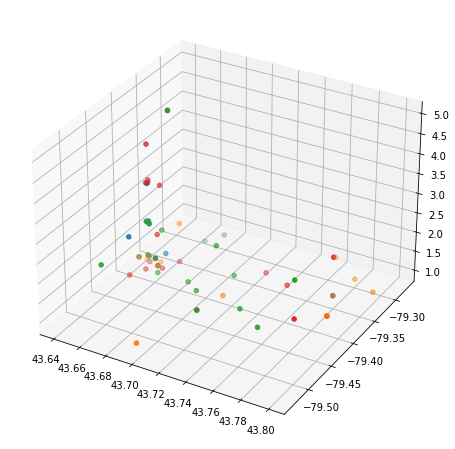

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
features = ['Asian', 'Chinese', 'Sushi', 'Japanese']

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(projection='3d')
for feature in features:
    df = df_tor.loc[df_tor[feature]!=0][['Coordinates', feature]]
    x=[val[0] for val in df['Coordinates'].values]
    y=[val[1] for val in df['Coordinates'].values]
    z=df[feature].values
    ax.scatter(x, y, z)
plt.show()

For example, it is interesting to compare the geographic distribution and density of Asian cuisine establishments (above) to those of Latin American flavour: 

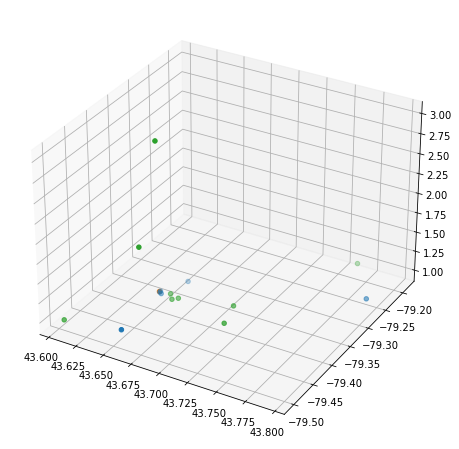

In [41]:
features = ['Latin American', 'Tacos', 'Mexican']

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(projection='3d')
for feature in features:
    df = df_tor.loc[df_tor[feature]!=0][['Coordinates', feature]]
    x=[val[0] for val in df['Coordinates'].values]
    y=[val[1] for val in df['Coordinates'].values]
    z=df[feature].values
    ax.scatter(x, y, z)
plt.show()